/tmp/ipython-input-2289288394.py:11: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if not pkgutil.find_loader("koreanize_matplotlib"):


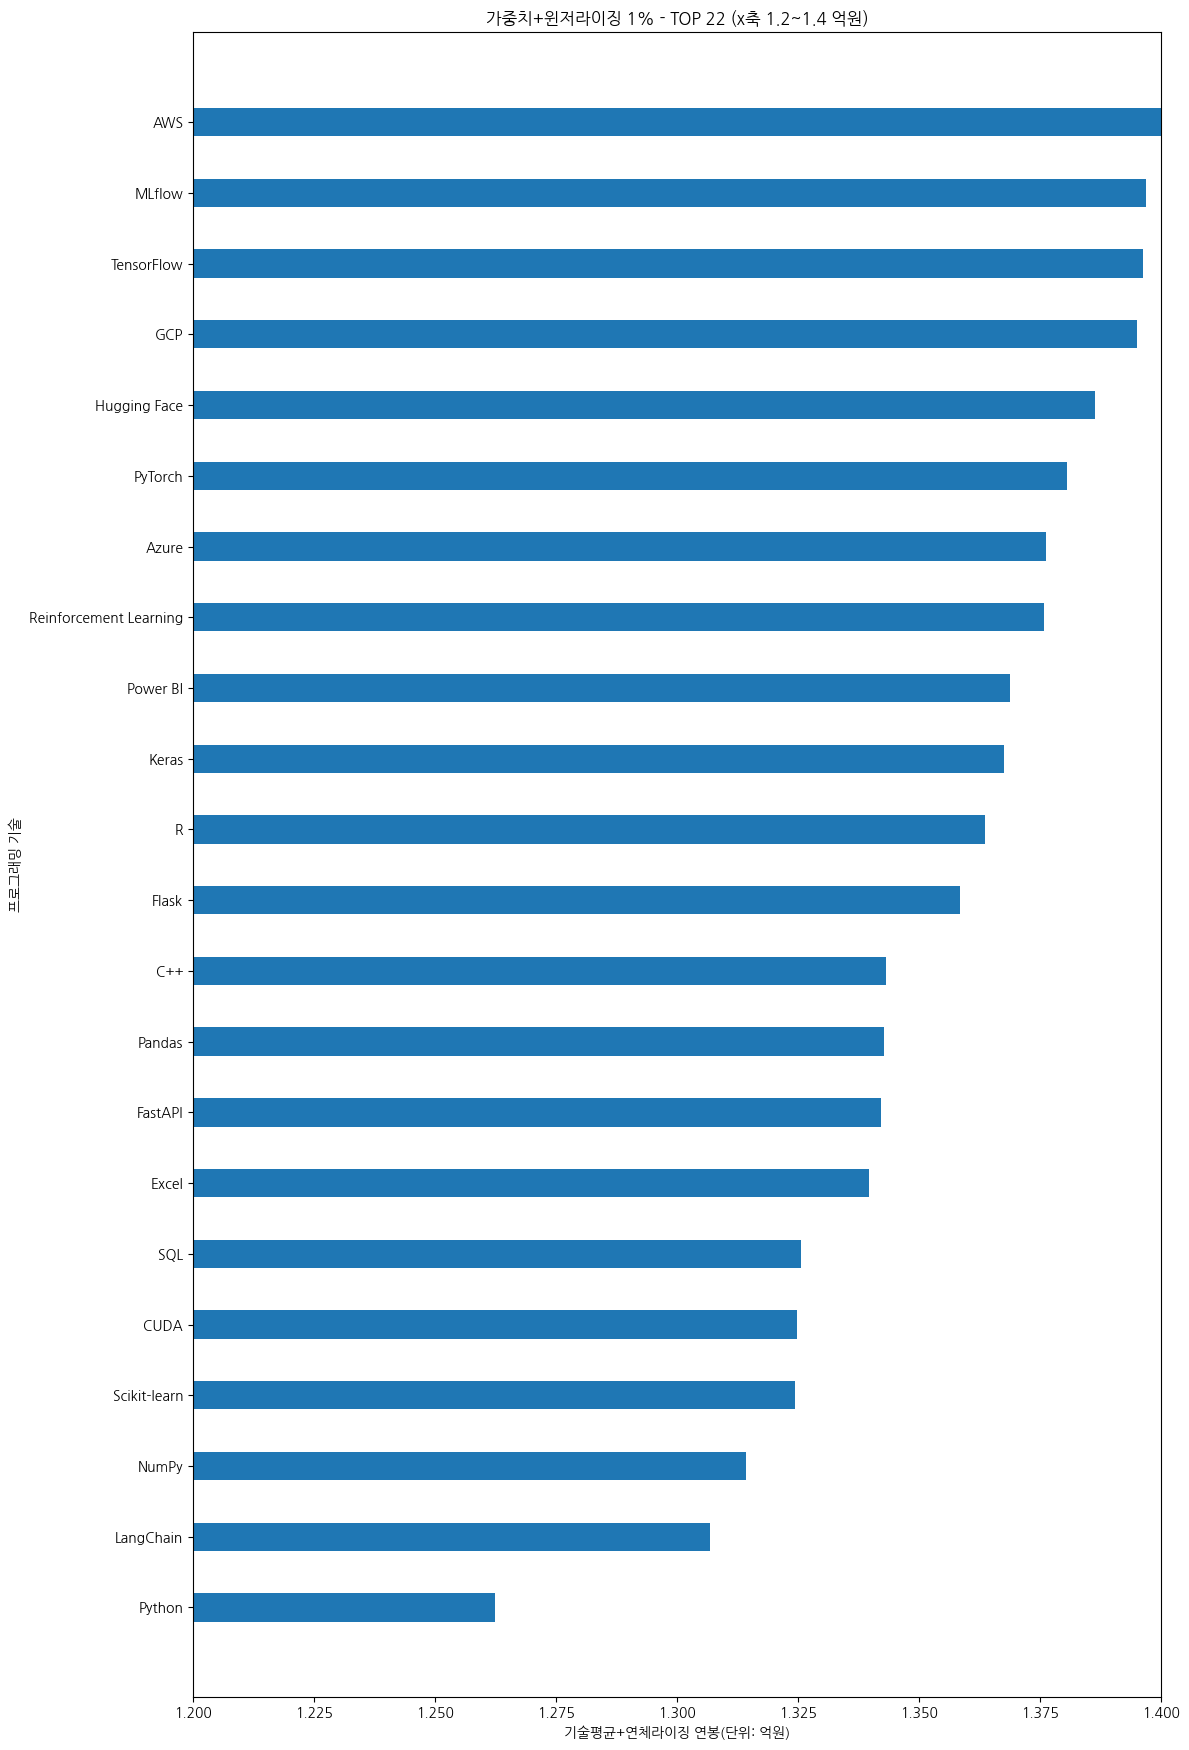

PosixPath('/mnt/data/가중치적용_winsor1_TOP22_억원_간격넓힘_xlim.png')

In [ ]:
# 재현 가능한 셀: (설치 → 폰트 적용 → 차트 생성)
# - 경로 수정: EXCEL_PATH는 /mnt/data 에 업로드된 파일 사용
# - 저장 경로 보장: 부모 폴더 생성
# - x축 범위: 1.2 ~ 1.4 (억원)
# - 막대 간격 확장(height=0.4, fig height 스케일업)
import sys, subprocess, pkgutil, os, re
from pathlib import Path

# 1) 폰트 패키지 설치
wheel_path = "/mnt/data/koreanize_matplotlib-0.1.1-py3-none-any.whl"
if not pkgutil.find_loader("koreanize_matplotlib"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", wheel_path])

# 2) 라이브러리 로드
from koreanize_matplotlib import koreanize_matplotlib  # noqa: F401
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 3) 경로/상수
EXCEL_PATH = Path("/content/기술연봉_정리.xlsx")  # <== 수정됨
USD_TO_KRW = 1420.84
OUT_PNG = Path("/mnt/data/가중치적용_winsor1_TOP22_억원_간격넓힘_xlim.png")
OUT_PNG.parent.mkdir(parents=True, exist_ok=True)  # 저장 경로 보장

# ------------------ 유틸 함수 ------------------
def load_excel_flexibly(path: Path) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=0, engine="openpyxl")
    df = df.iloc[:, :2].copy()
    df.rename(columns={df.columns[0]: "기술", df.columns[1]: "연봉(USD)"}, inplace=True)
    return df

def clean_salary_to_numeric(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip().str.replace(r"[^\d\.\-]", "", regex=True)
    s = s.replace({"": pd.NA, ".": pd.NA, "-": pd.NA})
    return pd.to_numeric(s, errors="coerce")

def tokenize_skills(text: str):
    t = re.sub(r"[\/;\|]", ",", text)
    parts = [p.strip() for p in t.split(",")]
    return [p for p in parts if p and p.lower() not in {"nan", "none"}]

def detect_role(token: str):
    low = token.lower()
    if any(m in low for m in ["[m]", "(m)", "주력"]): return "main"
    if any(m in low for m in ["[s]", "(s)", "보조"]): return "sub"
    return None

def strip_tags(token: str):
    t = re.sub(r"[\[\(]\s*[mMsS]\s*[\]\)]", "", token)
    t = t.replace("주력", "").replace("보조", "")
    return t.strip()

NORM_MAP = {
    "pytorch": "PyTorch", "torch": "PyTorch",
    "tensorflow": "TensorFlow", "tf": "TensorFlow",
    "keras": "Keras",
    "jax": "JAX",
    "huggingface": "Hugging Face", "hugging face": "Hugging Face",
    "mlflow": "MLflow",
    "langchain": "LangChain",
    "reinforcement learning": "Reinforcement Learning", "rl": "Reinforcement Learning",
    "scikit-learn": "Scikit-learn", "scikitlearn": "Scikit-learn", "sklearn": "Scikit-learn",
    "numpy": "NumPy",
    "pandas": "Pandas",
    "power bi": "Power BI", "powerbi": "Power BI",
    "excel": "Excel",
    "aws": "AWS",
    "gcp": "GCP", "google cloud": "GCP", "google cloud platform": "GCP",
    "azure": "Azure",
    "flask": "Flask",
    "fastapi": "FastAPI",
    "cuda": "CUDA",
    "c++": "C++", "cpp": "C++",
    "python": "Python",
    "sql": "SQL",
    "javascript": "JavaScript", "js": "JavaScript",
    "node.js": "Node.js", "nodejs": "Node.js",
    "postgresql": "PostgreSQL", "postgres": "PostgreSQL",
}
def normalize_skill(name: str) -> str:
    key = strip_tags(name)
    low = key.lower()
    return NORM_MAP.get(low, key)

WEIGHT_MAIN = 0.7
WEIGHT_REST = 0.3
def allocate_weights(tokens: list):
    roles = [detect_role(t) for t in tokens]
    if not any(r in ("main","sub") for r in roles):
        roles = ["main"] + ["sub"] * (len(tokens) - 1)
    n_main = sum(1 for r in roles if r=="main")
    n_sub  = sum(1 for r in roles if r=="sub")
    if len(tokens)==1:
        return [1.0]
    main_each = (WEIGHT_MAIN / n_main) if n_main>0 else 0.0
    sub_each  = (WEIGHT_REST / n_sub)  if n_sub>0 else 0.0
    weights = [main_each if r=="main" else sub_each for r in roles]
    s = sum(weights)
    return [w/s for w in weights] if s>0 else weights

def winsorize_and_aggregate_1pct(df_exp_w: pd.DataFrame):
    rows = []
    for skill, sub in df_exp_w.groupby("기술"):
        vals = sub["연봉(USD)"].astype(float).to_numpy()
        wts  = sub["가중치"].astype(float).to_numpy()
        if len(vals)==0 or np.sum(wts)==0:
            continue
        lo = np.quantile(vals, 0.01); hi = np.quantile(vals, 0.99)
        vals_w = np.clip(vals, lo, hi)
        wmean = np.average(vals_w, weights=wts) * USD_TO_KRW
        rows.append({"기술": skill, "가중평균+윈저라이징 연봉(원)": wmean})
    out = pd.DataFrame(rows).sort_values("가중평균+윈저라이징 연봉(원)", ascending=False).reset_index(drop=True)
    return out

# 4) 데이터 로드 및 전개
df0 = load_excel_flexibly(EXCEL_PATH)
df0["연봉(USD)"] = clean_salary_to_numeric(df0["연봉(USD)"])
df0 = df0.dropna(subset=["기술", "연봉(USD)"])

rows = []
for _, r in df0.iterrows():
    tokens = tokenize_skills(r["기술"])
    if not tokens:
        continue
    ws = allocate_weights(tokens)
    for tok, w in zip(tokens, ws):
        rows.append({"기술": normalize_skill(tok), "연봉(USD)": r["연봉(USD)"], "가중치": w})
df_exp_w = pd.DataFrame(rows)

# 5) 윈저라이징 1% + 억원 단위
stats_w1 = winsorize_and_aggregate_1pct(df_exp_w)
stats_w1["가중평균+윈저라이징 연봉(억원)"] = stats_w1["가중평균+윈저라이징 연봉(원)"] / 1e8
plot_df = stats_w1.head(22)

# 6) 차트: x축 1.2~1.4 (억원), 간격 확대
plt.figure(figsize=(12, max(4, 0.8*len(plot_df))))
plt.barh(plot_df["기술"], plot_df["가중평균+윈저라이징 연봉(억원)"], height=0.4)
plt.gca().invert_yaxis()
plt.xlim(1.2, 1.4)
plt.xlabel("기술평균+연체라이징 연봉(단위: 억원)")
plt.ylabel("프로그래밍 기술")
plt.title("가중치+윈저라이징 1% - TOP 22 (x축 1.2~1.4 억원)")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=150, bbox_inches="tight")
plt.show()

# 산출물 경로 출력
OUT_PNG
